In [3]:
# %% [markdown]
# # Ablation Appendix Plots
# Utilidad: graficar análisis de ablación (greedy) a partir de summary_ablation.csv

# %%
import os
import re
import math
from pathlib import Path
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- Parámetros (ajusta según tu repo) ----------
SUMMARY_CSV = Path("/home/diego/Escritorio/limpio/ablation_full_run_fast/summary_ablation.csv")  # <- ruta al CSV resumen
FIGS_DIR    = Path("Figures")                             # <- donde se guardan las figuras
PAPER_DPI   = 300
N_FOLDS_DEFAULT = 5                                       # <- fallback si no se puede inferir de metrics_csv

# Etiquetas bonitas para canales (opcional; si viene en el CSV ya parseamos de ahí)
DEFAULT_CHANNEL_NAMES = {
    0: 'Pearson_OMST_GCE_Signed_Weighted',
    1: 'Pearson_Full_FisherZ_Signed',
    2: 'MI_KNN_Symmetric',
    3: 'dFC_AbsDiffMean',
    4: 'dFC_StdDev',
    5: 'DistanceCorr',
    6: 'Granger_F_lag1',
}

# Estética de las figuras (tamaños adecuados para LaTeX 1-col/2-col)
plt.rcParams.update({
    "figure.figsize": (6.0, 4.0),  # tamaño default; cada plot lo puede sobrescribir
    "font.size": 10,               # compatible con \documentclass[10pt]
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": PAPER_DPI,
})

FIGS_DIR.mkdir(parents=True, exist_ok=True)
print("Usando:", SUMMARY_CSV.resolve())



Usando: /home/diego/Escritorio/limpio/ablation_full_run_fast/summary_ablation.csv


In [4]:
# %%
# Cargar summary_ablation.csv
df = pd.read_csv(SUMMARY_CSV)

# Normalizar tipos
df["step"] = pd.to_numeric(df["step"], errors="coerce").astype("Int64")
df["metric_mean"] = pd.to_numeric(df["metric_mean"], errors="coerce")
df["metric_std"]  = pd.to_numeric(df["metric_std"],  errors="coerce")

# Parsear lista de índices de canales (columna "channels_indices": "1 2 5", etc.)
def parse_idx_list(s):
    if isinstance(s, str):
        s = s.strip()
        if not s:
            return []
        return [int(x) for x in s.split()]
    return []

df["channels_idx_list"] = df["channels_indices"].apply(parse_idx_list)
df["n_channels"] = df["channels_idx_list"].apply(len)

# Parsear nombres bonitos desde "channels_pretty" (ej: "[1:NameA, 2:NameB]")
def parse_pretty_names(s):
    if not isinstance(s, str):
        return []
    s = s.strip().strip("[]")
    if not s:
        return []
    names = []
    for part in s.split(","):
        part = part.strip()
        # Formato esperado: "1:SomeName"
        if ":" in part:
            idx, name = part.split(":", 1)
            names.append(name.strip())
        else:
            names.append(part)
    return names

df["channels_names"] = df["channels_pretty"].apply(parse_pretty_names)

# Orden natural por paso (0 = mejor single en nuestro orquestador)
df = df.sort_values(["step", "n_channels"]).reset_index(drop=True)

# Δ vs paso previo a float (puede venir con "+0.00123")
def parse_delta(s):
    try:
        return float(str(s).replace("+",""))
    except:
        return np.nan

df["delta_vs_prev_float"] = df["delta_vs_prev"].apply(parse_delta)

display(df.head(10))
print(f"Pasos totales: {df['step'].nunique()} | filas: {len(df)}")


,step,channels_indices,channels_pretty,classifier,metric,metric_mean,metric_std,delta_vs_prev,out_dir,metrics_csv,channels_idx_list,n_channels,channels_names,delta_vs_prev_float
0,0,1,[1:Pearson_Full_FisherZ_Signed],logreg,auc,0.748163,0.056767,NaN,ablation_full_run_fast/single_ch1,ablation_full_run_fast/single_ch1/all_folds_me...,[1],1,[Pearson_Full_FisherZ_Signed],NaN
1,1,1 5,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr]",logreg,auc,0.759238,0.043619,0.011075,ablation_full_run_fast/step1_add_ch5_set_1_5,ablation_full_run_fast/step1_add_ch5_set_1_5/a...,"[1, 5]",2,"[Pearson_Full_FisherZ_Signed, DistanceCorr]",0.011075
2,2,1 5 2,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.748467,0.016932,-0.010772,ablation_full_run_fast/step2_add_ch2_set_1_5_2,ablation_full_run_fast/step2_add_ch2_set_1_5_2...,"[1, 5, 2]",3,"[Pearson_Full_FisherZ_Signed, DistanceCorr, MI...",-0.010772
3,3,1 5 2 4,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.743091,0.034163,-0.005376,ablation_full_run_fast/step3_add_ch4_set_1_5_2_4,ablation_full_run_fast/step3_add_ch4_set_1_5_2...,"[1, 5, 2, 4]",4,"[Pearson_Full_FisherZ_Signed, DistanceCorr, MI...",-0.005376
4,4,1 5 2 4 0,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.716515,0.025084,-0.026576,ablation_full_run_fast/step4_add_ch0_set_1_5_2...,ablation_full_run_fast/step4_add_ch0_set_1_5_2...,"[1, 5, 2, 4, 0]",5,"[Pearson_Full_FisherZ_Signed, DistanceCorr, MI...",-0.026576
5,5,1 5 2 4 0 6,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.740148,0.042772,0.023633,ablation_full_run_fast/step5_add_ch6_set_1_5_2...,ablation_full_run_fast/step5_add_ch6_set_1_5_2...,"[1, 5, 2, 4, 0, 6]",6,"[Pearson_Full_FisherZ_Signed, DistanceCorr, MI...",0.023633
6,6,1 5 2 4 0 6 3,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.699985,0.066314,-0.040163,ablation_full_run_fast/step6_add_ch3_set_1_5_2...,ablation_full_run_fast/step6_add_ch3_set_1_5_2...,"[1, 5, 2, 4, 0, 6, 3]",7,"[Pearson_Full_FisherZ_Signed, DistanceCorr, MI...",-0.040163


Pasos totales: 7 | filas: 7


In [5]:
# %%
# Intento robusto de obtener #folds desde cada metrics_csv
def infer_n_folds(metrics_csv_path: str) -> int:
    try:
        mdf = pd.read_csv(metrics_csv_path)
    except Exception:
        return N_FOLDS_DEFAULT

    # Columnas candidatas que suelen aparecer
    fold_cols = [c for c in mdf.columns if re.search(r"fold|outer", c, re.I)]
    # Si hay una columna con índices de fold, usamos su número de valores únicos
    for col in fold_cols:
        try:
            n = pd.Series(mdf[col]).nunique()
            if 1 <= n <= 20:  # rango razonable
                return int(n)
        except Exception:
            pass

    # Si no hay columnas explícitas, probamos heurísticas:
    # - Si el CSV contiene una fila por fold para el clasificador actual,
    #   podemos contar filas filtrando por 'actual_classifier_type' si existe.
    try:
        if "actual_classifier_type" in mdf.columns:
            # Usar el primero que aparezca (el mismo del summary)
            clf = df.loc[0, "classifier"] if "classifier" in df.columns else None
            sub = mdf if clf is None else mdf[mdf["actual_classifier_type"] == clf]
            # n_filas puede ser n_folds si el CSV tiene 1 fila por fold
            if 1 < len(sub) <= 20:
                return int(len(sub))
    except Exception:
        pass

    # Fallback
    return N_FOLDS_DEFAULT

# Agregar columna con n_folds (fila a fila, usando su propio metrics_csv)
df["n_folds_inferred"] = df["metrics_csv"].apply(infer_n_folds)
df["std_err"] = df["metric_std"] / np.sqrt(df["n_folds_inferred"].clip(lower=1))

df[["step","n_channels","metric_mean","metric_std","n_folds_inferred","std_err"]].head(10)


,step,n_channels,metric_mean,metric_std,n_folds_inferred,std_err
0,0,1,0.748163,0.056767,3,0.032774
1,1,2,0.759238,0.043619,3,0.025183
2,2,3,0.748467,0.016932,3,0.009776
3,3,4,0.743091,0.034163,3,0.019724
4,4,5,0.716515,0.025084,3,0.014482
5,5,6,0.740148,0.042772,3,0.024694
6,6,7,0.699985,0.066314,3,0.038286


In [6]:
# %%
# Para el gráfico de curva, queremos saber qué canal se añadió en cada paso
def incremental_label(row, prev_row):
    if prev_row is None:
        # Paso 0 (semilla): listamos el/los nombres de ese set
        if row["channels_names"]:
            return " + ".join(row["channels_names"])
        # fallback a indices->nombres
        return " + ".join(DEFAULT_CHANNEL_NAMES.get(i, f"Ch{i}") for i in row["channels_idx_list"])

    prev_set = set(prev_row["channels_idx_list"])
    curr_set = set(row["channels_idx_list"])
    added = list(curr_set - prev_set)
    if not added:
        return ""
    # si tenemos nombres ya parseados
    if row["channels_names"] and len(row["channels_names"]) == len(row["channels_idx_list"]):
        # Suponemos que el orden de names sigue al de indices
        idx_to_name = dict(zip(row["channels_idx_list"], row["channels_names"]))
    else:
        idx_to_name = {i: DEFAULT_CHANNEL_NAMES.get(i, f"Ch{i}") for i in row["channels_idx_list"]}

    return " + " + " + ".join(idx_to_name.get(i, f"Ch{i}") for i in added)

# Determinar mejor paso global (por métrica media)
best_idx = int(df["metric_mean"].idxmax())
best_row = df.loc[best_idx]
best_mean = float(best_row["metric_mean"])
best_se   = float(best_row["std_err"])

# Con la regla 1-SE: elegimos el **mínimo #de canales** con mean >= (best_mean - best_se)
threshold = best_mean - best_se
candidates = df[df["metric_mean"] >= threshold]
parsimonious_idx = int(candidates.sort_values(["n_channels","metric_mean"], ascending=[True, False]).index[0])
parsimonious_row = df.loc[parsimonious_idx]

print(f"Mejor paso (max mean): step={int(best_row['step'])}, n={int(best_row['n_channels'])}, "
      f"{best_mean:.4f} ± {best_se:.4f} (SE)")

print(f"Óptimo parsimonioso (1-SE): step={int(parsimonious_row['step'])}, "
      f"n={int(parsimonious_row['n_channels'])}, mean={parsimonious_row['metric_mean']:.4f}")

# Preparamos etiquetas incrementales
labels_inc = []
prev = None
for _, r in df.iterrows():
    labels_inc.append(incremental_label(r, prev))
    prev = r

df["label_incremental"] = labels_inc
df[["step","n_channels","metric_mean","std_err","label_incremental"]].head(10)


Mejor paso (max mean): step=1, n=2, 0.7592 ± 0.0252 (SE)
Óptimo parsimonioso (1-SE): step=0, n=1, mean=0.7482


,step,n_channels,metric_mean,std_err,label_incremental
0,0,1,0.748163,0.032774,Pearson_Full_FisherZ_Signed
1,1,2,0.759238,0.025183,+ DistanceCorr
2,2,3,0.748467,0.009776,+ MI_KNN_Symmetric
3,3,4,0.743091,0.019724,+ dFC_StdDev
4,4,5,0.716515,0.014482,+ Pearson_OMST_GCE_Signed_Weighted
5,5,6,0.740148,0.024694,+ Granger_F_lag1
6,6,7,0.699985,0.038286,+ dFC_AbsDiffMean


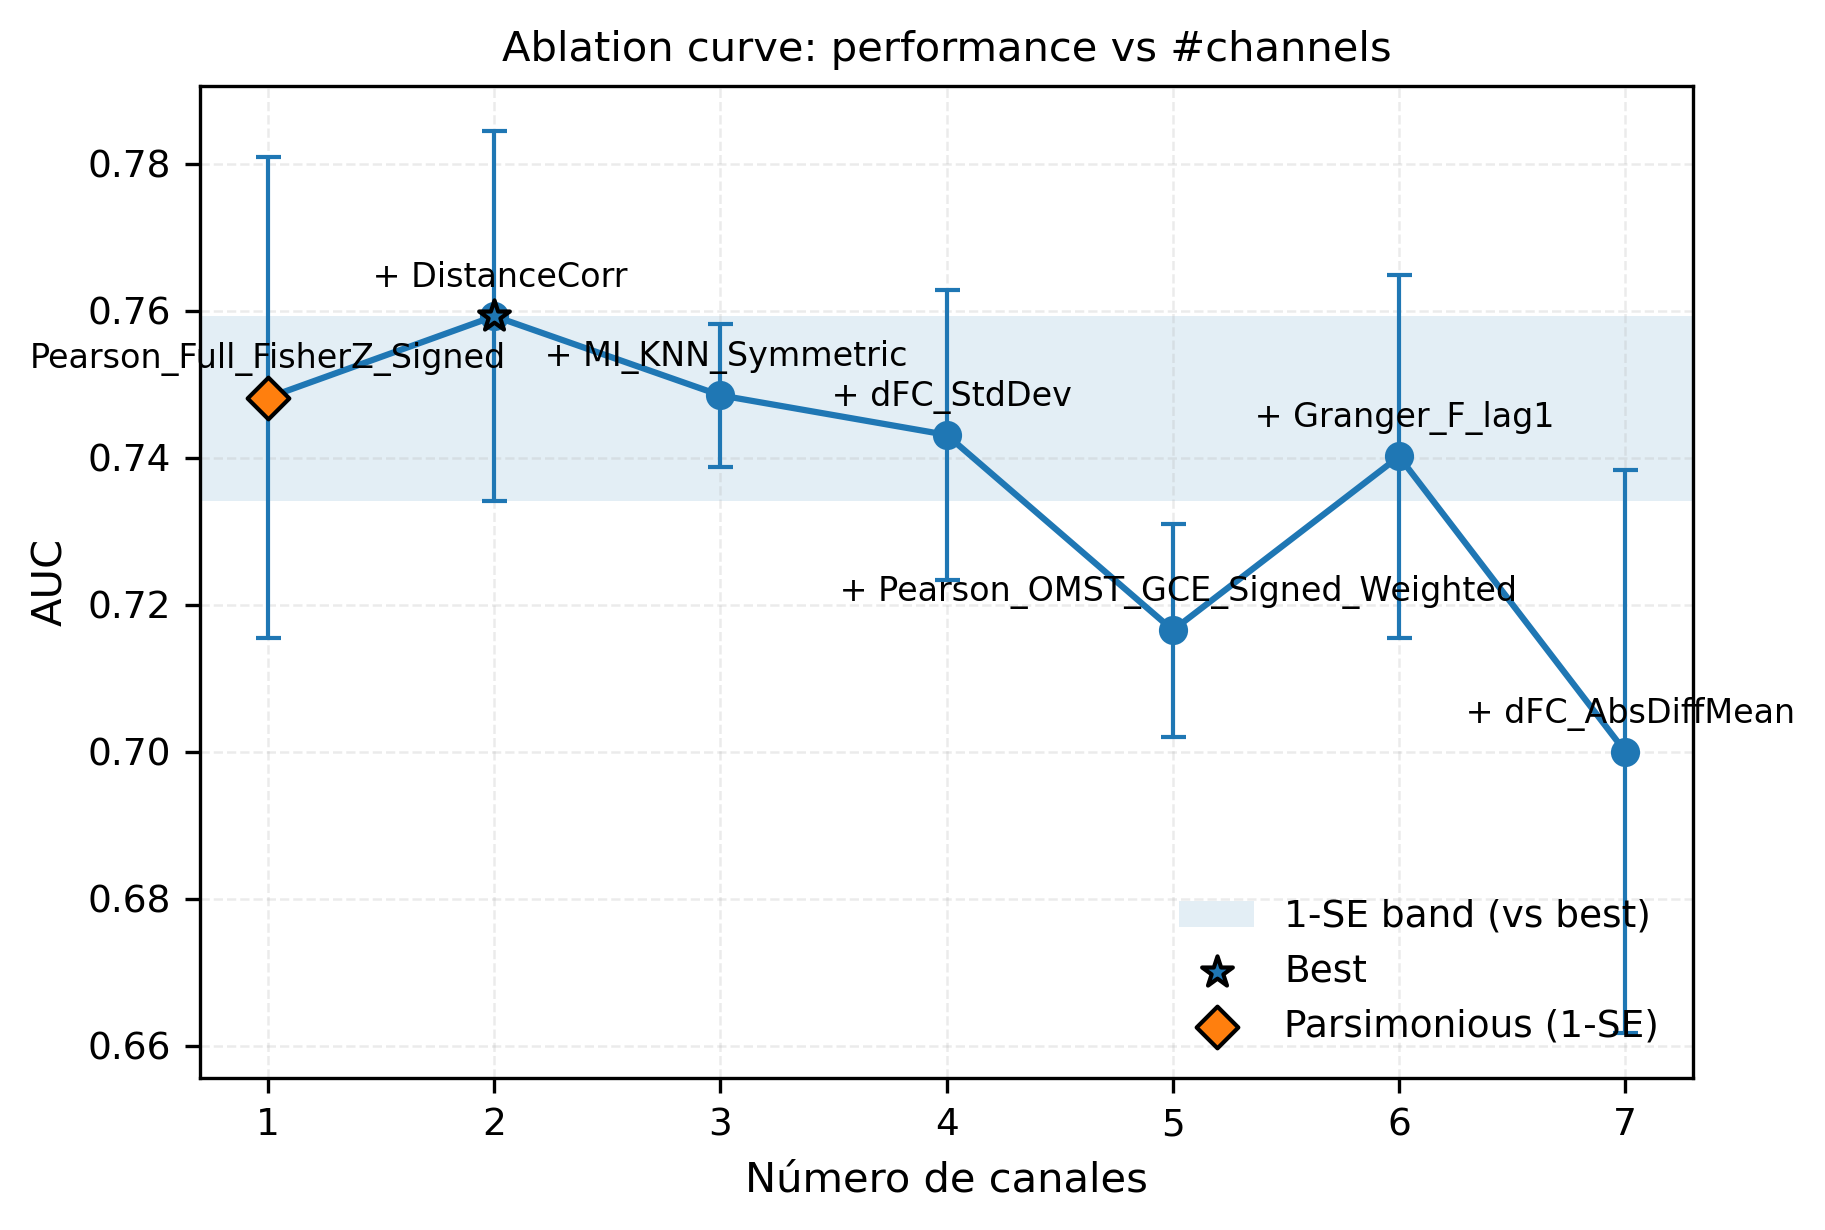

Guardado: Figures/fig_ablation_curve.png | Figures/fig_ablation_curve.pdf


In [7]:
# %%
# Plot: curva rendimiento vs número de canales, con barras de error (SE) y banda 1-SE
x = df["n_channels"].values
y = df["metric_mean"].values
se = df["std_err"].values

fig, ax = plt.subplots(figsize=(6.2, 4.2))
ax.plot(x, y, marker="o", linewidth=1.5)
ax.errorbar(x, y, yerr=se, fmt="none", capsize=3, linewidth=1)

# Banda 1-SE (respecto al mejor)
ax.axhspan(threshold, best_mean, alpha=0.12, lw=0, label="1-SE band (vs best)")

# Destacar puntos "best" y "parsimonious"
ax.scatter([best_row["n_channels"]], [best_mean], s=60, zorder=3, marker="*", label="Best", edgecolor="k")
ax.scatter([parsimonious_row["n_channels"]], [parsimonious_row["metric_mean"]], s=50, zorder=3, marker="D", label="Parsimonious (1-SE)", edgecolor="k")

# Etiquetas incrementales pequeñas arriba de cada punto (opcional)
for xi, yi, lbl in zip(x, y, df["label_incremental"].values):
    if lbl:
        ax.annotate(lbl, (xi, yi), textcoords="offset points", xytext=(0, 7), ha="center", fontsize=8, rotation=0)

ax.set_xlabel("Número de canales")
ax.set_ylabel(df.loc[0, "metric"].upper() if "metric" in df.columns else "AUC")
ax.set_title("Ablation curve: performance vs #channels")
ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.6)
ax.legend(loc="lower right", frameon=False)

out_png = FIGS_DIR / "fig_ablation_curve.png"
out_pdf = FIGS_DIR / "fig_ablation_curve.pdf"
plt.tight_layout()
plt.savefig(out_png, dpi=PAPER_DPI)
plt.savefig(out_pdf)
plt.show()

print("Guardado:", out_png, "|", out_pdf)


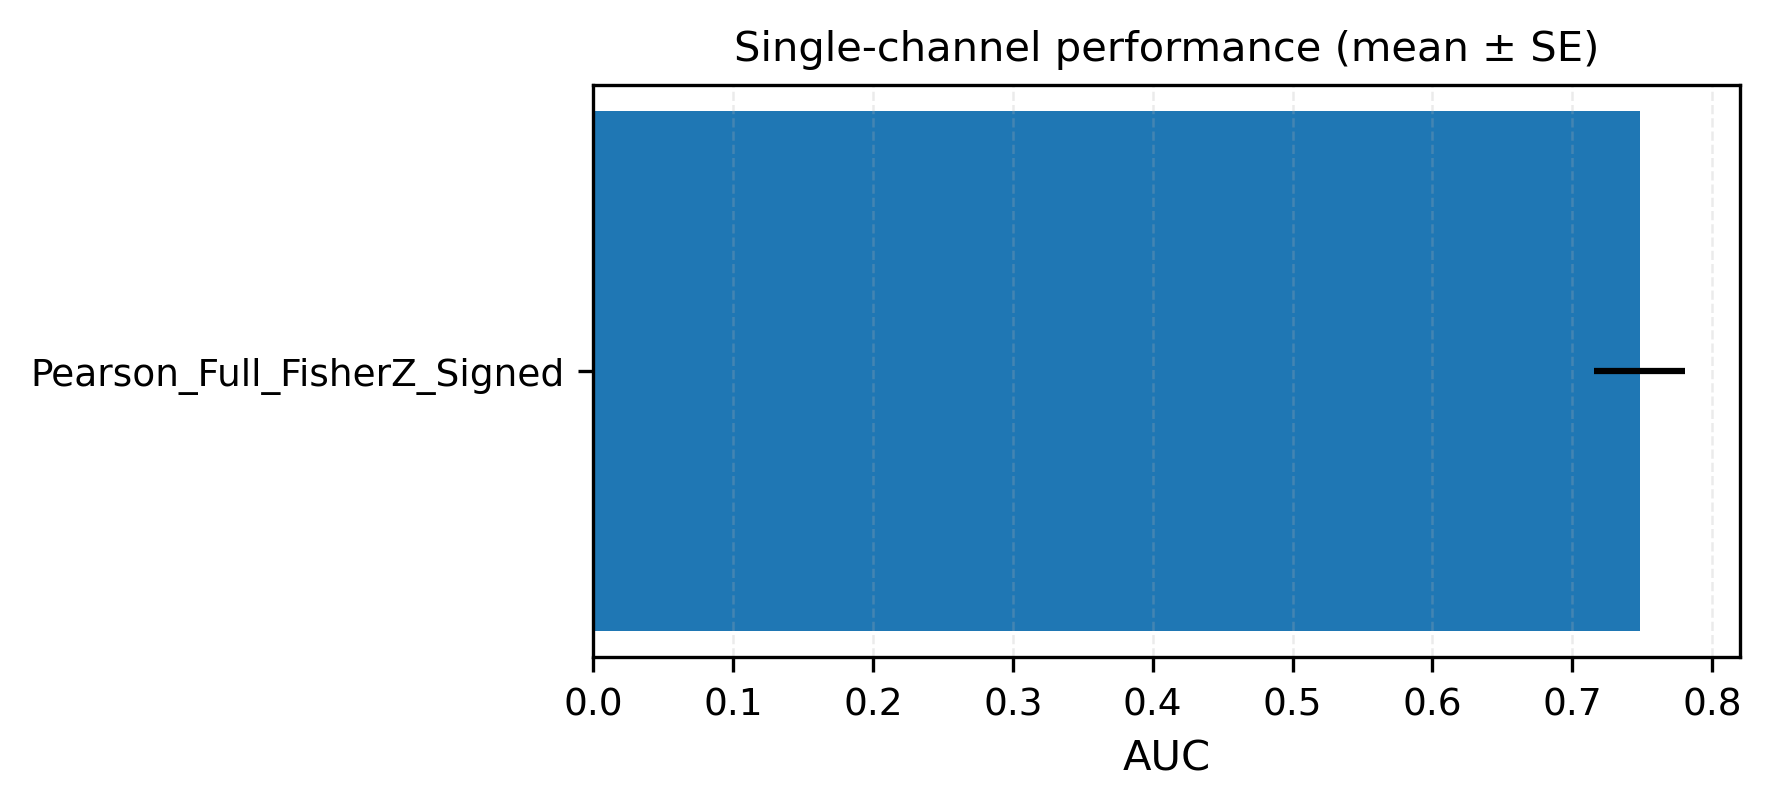

Guardado: Figures/fig_ablation_single_channels.png | Figures/fig_ablation_single_channels.pdf


In [8]:
# %%
# Filtrar pasos con un solo canal
singles = df[df["n_channels"] == 1].copy()
if singles.empty:
    print("No se encontraron corridas de 'single-channel' en el resumen.")
else:
    # Extraer nombre del canal (mejor desde channels_names; fallback al diccionario)
    def lone_name(row):
        if row["channels_names"]:
            return row["channels_names"][0]
        idx = row["channels_idx_list"][0] if row["channels_idx_list"] else None
        return DEFAULT_CHANNEL_NAMES.get(idx, f"Ch{idx}")

    singles["channel_name"] = singles.apply(lone_name, axis=1)

    # Ordenar por métrica
    singles = singles.sort_values("metric_mean", ascending=True)

    fig, ax = plt.subplots(figsize=(6.0, max(2.8, 0.35*len(singles))))
    ax.barh(singles["channel_name"], singles["metric_mean"], xerr=singles["std_err"], height=0.6)
    ax.set_xlabel(df.loc[0, "metric"].upper() if "metric" in df.columns else "AUC")
    ax.set_title("Single-channel performance (mean ± SE)")
    ax.grid(True, axis="x", alpha=0.25, linestyle="--", linewidth=0.6)

    out_png = FIGS_DIR / "fig_ablation_single_channels.png"
    out_pdf = FIGS_DIR / "fig_ablation_single_channels.pdf"
    plt.tight_layout()
    plt.savefig(out_png, dpi=PAPER_DPI)
    plt.savefig(out_pdf)
    plt.show()

    print("Guardado:", out_png, "|", out_pdf)


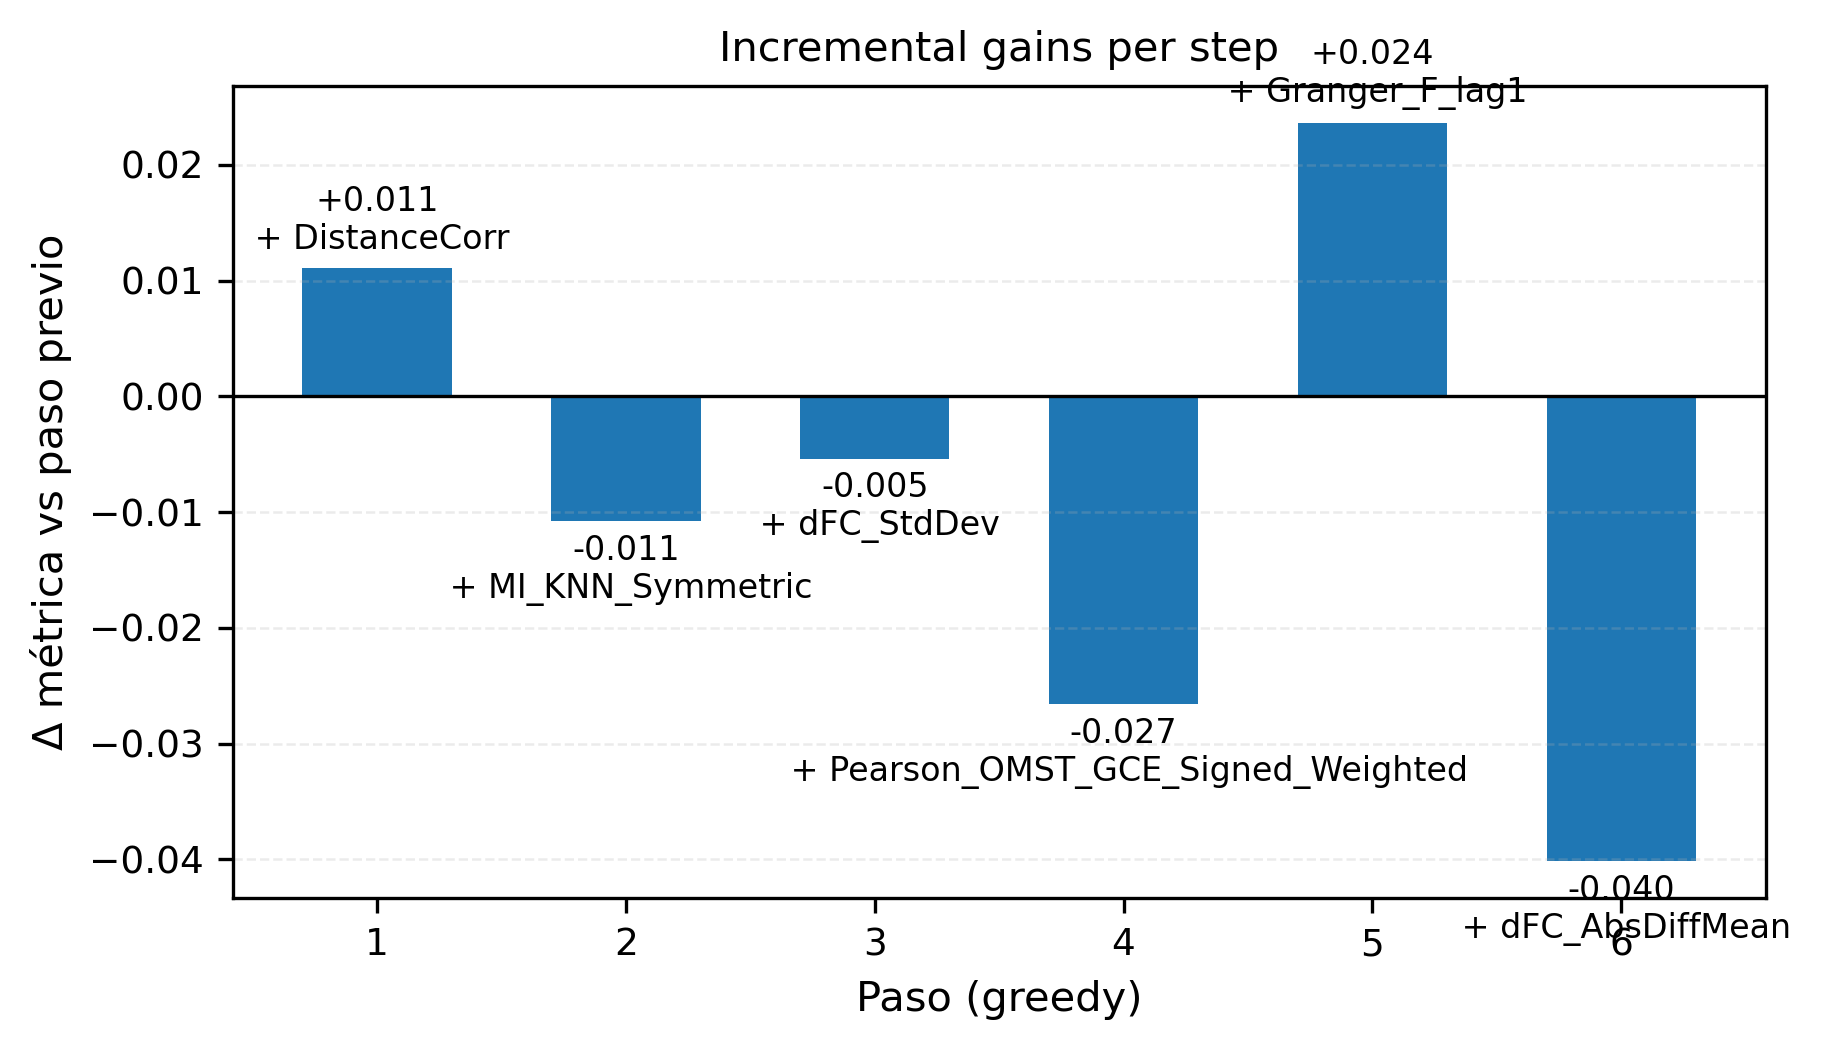

Guardado: Figures/fig_ablation_gains.png | Figures/fig_ablation_gains.pdf


In [9]:
# %%
# Ganancias vs paso previo (delta_vs_prev_float); ignoramos NaN en step 0
gains = df.dropna(subset=["delta_vs_prev_float"]).copy()

if gains.empty:
    print("No hay columna delta_vs_prev en el resumen o no tiene datos.")
else:
    fig, ax = plt.subplots(figsize=(6.2, 3.6))
    ax.axhline(0, color="k", linewidth=0.8)
    ax.bar(gains["step"].astype(int), gains["delta_vs_prev_float"], width=0.6)
    ax.set_xlabel("Paso (greedy)")
    ax.set_ylabel("Δ métrica vs paso previo")
    ax.set_title("Incremental gains per step")
    ax.grid(True, axis="y", alpha=0.25, linestyle="--", linewidth=0.6)

    # Etiquetar la ganancia y el canal agregado en cada paso
    for _, r in gains.iterrows():
        v = r["delta_vs_prev_float"]
        lbl = r.get("label_incremental", "")
        ax.annotate(f"{v:+.3f}\n{lbl}", (int(r["step"]), v), ha="center",
                    va="bottom" if v>=0 else "top", fontsize=8, xytext=(0, 3 if v>=0 else -3),
                    textcoords="offset points")

    out_png = FIGS_DIR / "fig_ablation_gains.png"
    out_pdf = FIGS_DIR / "fig_ablation_gains.pdf"
    plt.tight_layout()
    plt.savefig(out_png, dpi=PAPER_DPI)
    plt.savefig(out_pdf)
    plt.show()

    print("Guardado:", out_png, "|", out_pdf)


Archivo 'summary_ablation.csv' cargado. Contiene las siguientes filas:


,step,channels_indices,channels_pretty,classifier,metric,metric_mean,metric_std,delta_vs_prev,out_dir,metrics_csv
0,0,1,[1:Pearson_Full_FisherZ_Signed],logreg,auc,0.748163,0.056767,NaN,ablation_full_run_fast/single_ch1,ablation_full_run_fast/single_ch1/all_folds_me...
1,1,1 5,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr]",logreg,auc,0.759238,0.043619,0.011075,ablation_full_run_fast/step1_add_ch5_set_1_5,ablation_full_run_fast/step1_add_ch5_set_1_5/a...
2,2,1 5 2,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.748467,0.016932,-0.010772,ablation_full_run_fast/step2_add_ch2_set_1_5_2,ablation_full_run_fast/step2_add_ch2_set_1_5_2...
3,3,1 5 2 4,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.743091,0.034163,-0.005376,ablation_full_run_fast/step3_add_ch4_set_1_5_2_4,ablation_full_run_fast/step3_add_ch4_set_1_5_2...
4,4,1 5 2 4 0,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.716515,0.025084,-0.026576,ablation_full_run_fast/step4_add_ch0_set_1_5_2...,ablation_full_run_fast/step4_add_ch0_set_1_5_2...
5,5,1 5 2 4 0 6,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.740148,0.042772,0.023633,ablation_full_run_fast/step5_add_ch6_set_1_5_2...,ablation_full_run_fast/step5_add_ch6_set_1_5_2...
6,6,1 5 2 4 0 6 3,"[1:Pearson_Full_FisherZ_Signed, 5:DistanceCorr...",logreg,auc,0.699985,0.066314,-0.040163,ablation_full_run_fast/step6_add_ch3_set_1_5_2...,ablation_full_run_fast/step6_add_ch3_set_1_5_2...


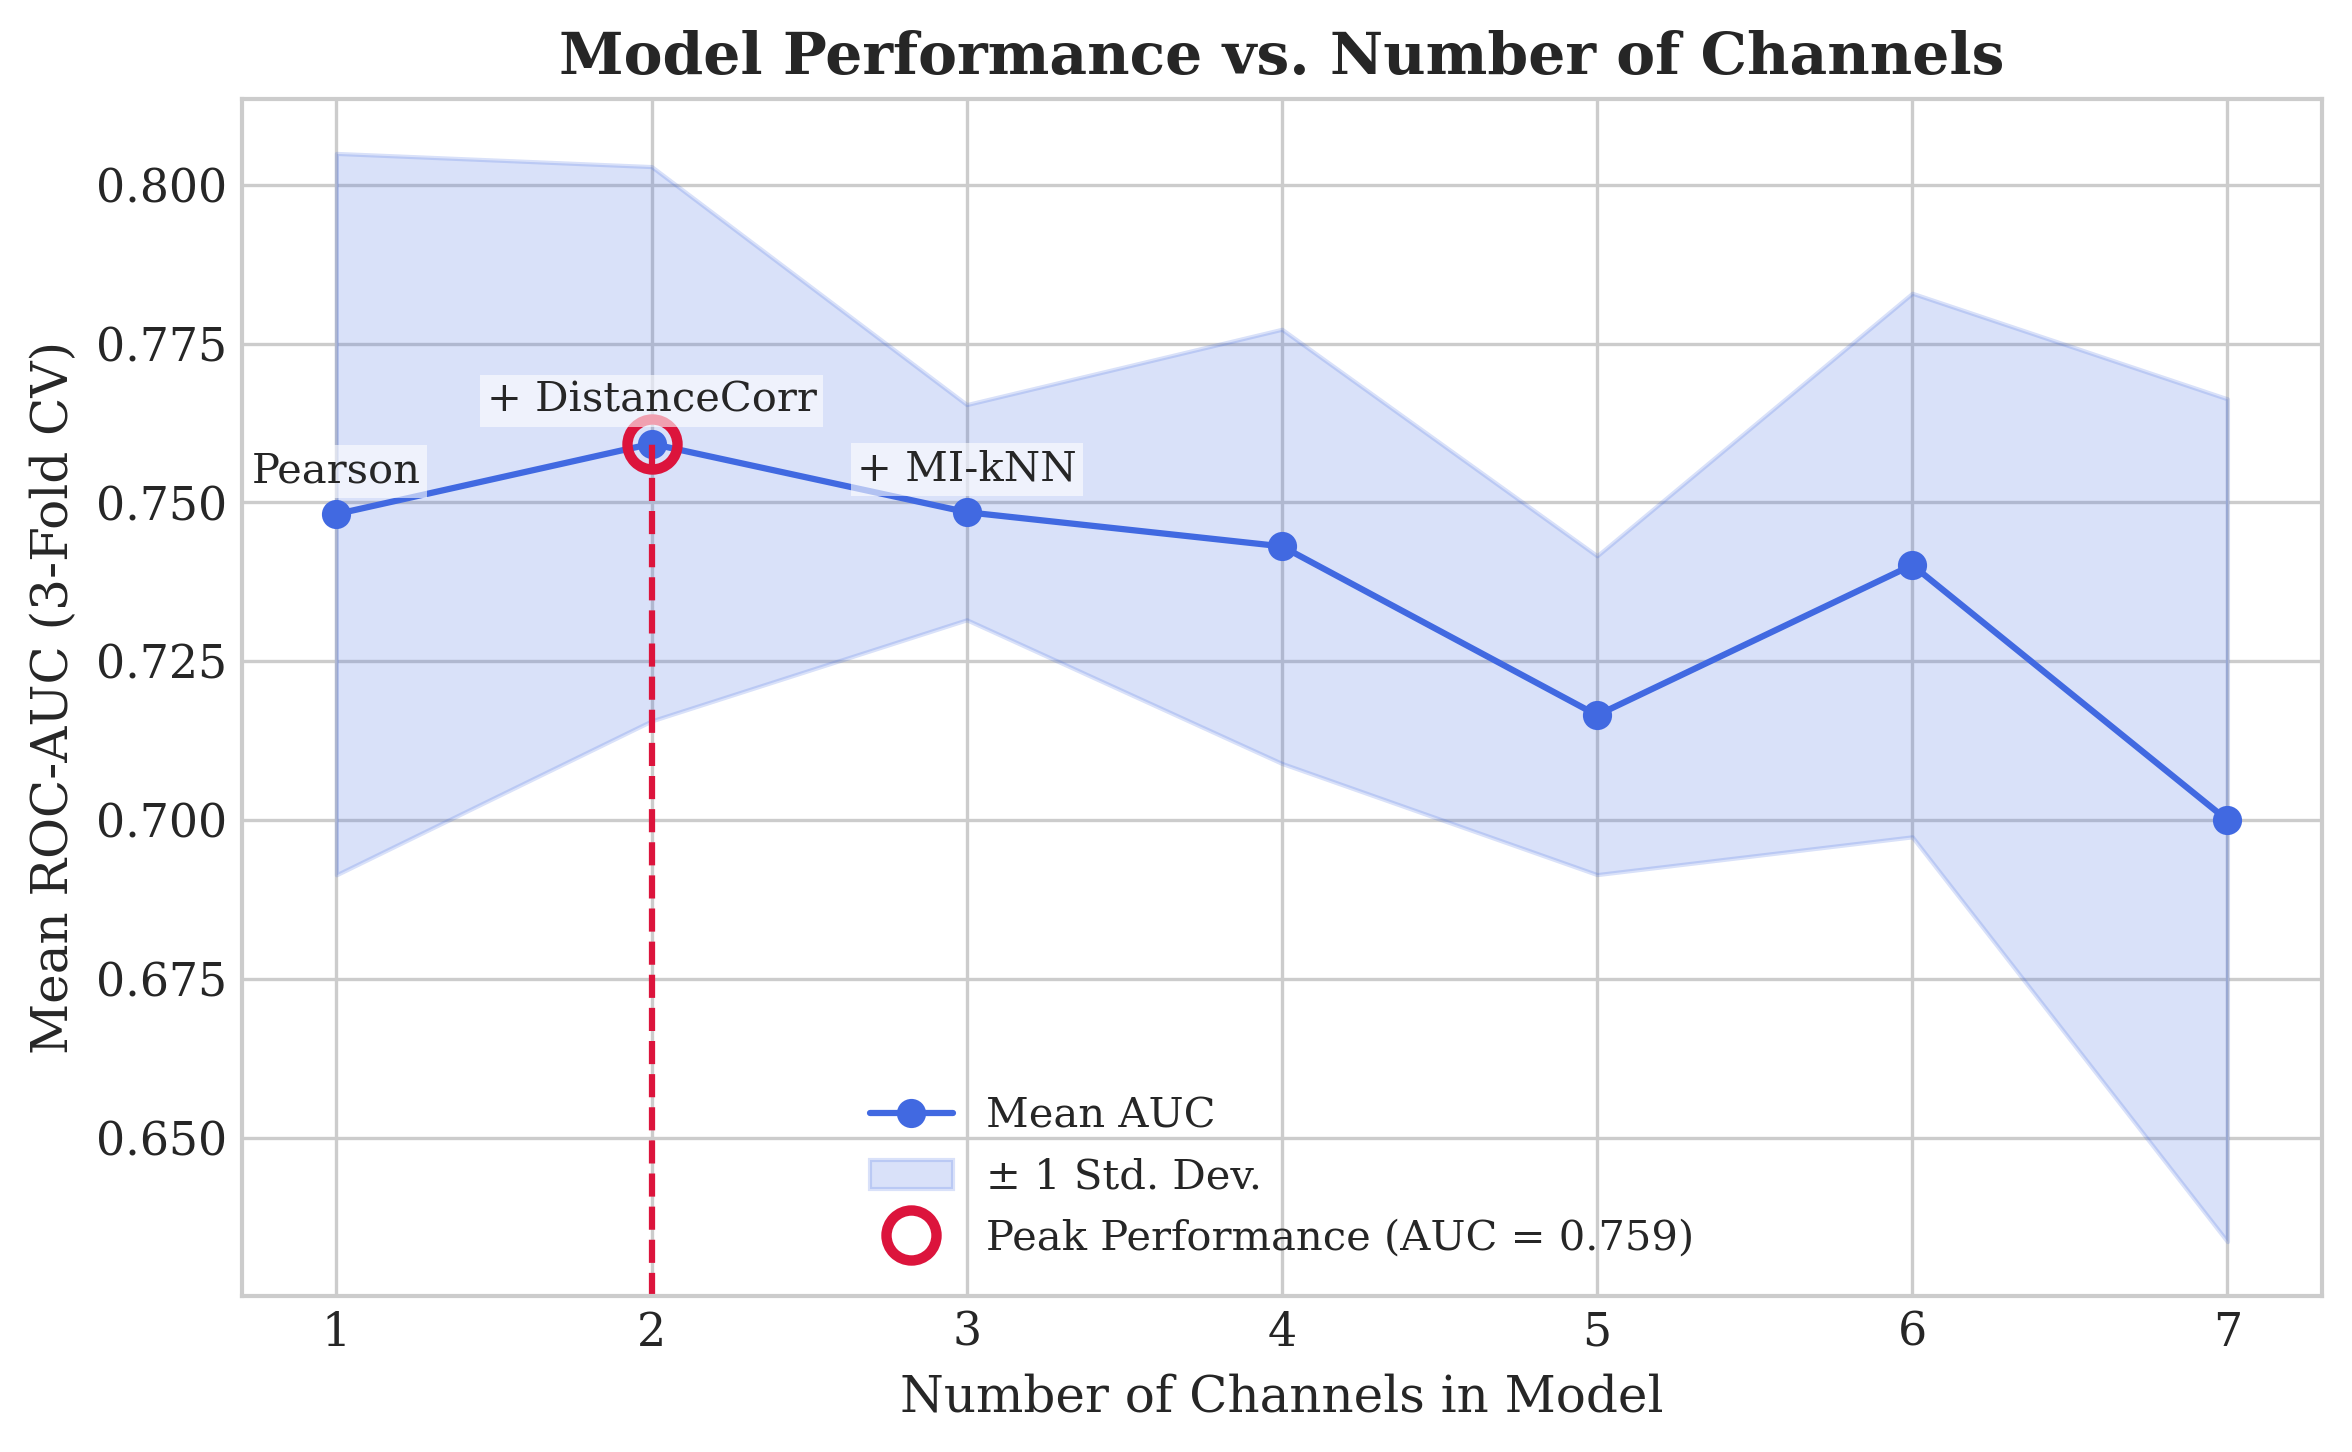


Gráfico guardado como 'Fig_Appendix_AblationCurve.png' y 'Fig_Appendix_AblationCurve.pdf'


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# --- 1. Configuración y Carga de Datos ---
SUMMARY_CSV = '/home/diego/Escritorio/limpio/ablation_full_run_fast/summary_ablation.csv'  # Asegúrate que este archivo esté en la misma carpeta

# Estilo para publicación
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 10

try:
    df = pd.read_csv(SUMMARY_CSV)
    print("Archivo 'summary_ablation.csv' cargado. Contiene las siguientes filas:")
    display(df)
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{SUMMARY_CSV}'.")
    df = None

# --- 2. Creación del Gráfico (si los datos se cargaron)---
if df is not None and not df.empty:
    df['n_channels'] = df['channels_indices'].str.split().str.len()
    df = df.sort_values('n_channels').reset_index(drop=True)

    # --- Creación del Gráfico ---
    fig, ax = plt.subplots()

    x_values = df['n_channels']
    y_values = df['metric_mean']
    y_std = df['metric_std']

    # Línea principal y banda de error
    ax.plot(x_values, y_values, marker='o', linestyle='-', color='royalblue', label='Mean AUC')
    ax.fill_between(x_values, y_values - y_std, y_values + y_std, color='royalblue', alpha=0.2, label='± 1 Std. Dev.')

    # --- Anotaciones y Puntos Clave ---
    peak_idx = y_values.idxmax()
    peak_x = x_values[peak_idx]
    peak_y = y_values[peak_idx]
    
    # Resaltar el pico
    ax.axvline(x=peak_x, color='crimson', linestyle='--', linewidth=1.5, ymax=(peak_y - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
    ax.plot(peak_x, peak_y, 'o', markersize=12, color='crimson', mfc='none', mew=2.5, label=f'Peak Performance (AUC = {peak_y:.3f})')

    # Nombres de los canales añadidos
    channel_names_added = [
        'Pearson',         # Step 0 -> 1 Channel
        '+ DistanceCorr',    # Step 1 -> 2 Channels
        '+ MI-kNN'           # Step 2 -> 3 Channels
    ]

    for i, label in enumerate(channel_names_added):
        if i < len(df):
            ax.text(x_values[i], y_values[i] + 0.005, label, ha='center', fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1.5))

    # --- Títulos y Etiquetas ---
    ax.set_title('Model Performance vs. Number of Channels', fontweight='bold')
    ax.set_xlabel('Number of Channels in Model')
    # OJO: La métrica es AUC, no Balanced Accuracy. Deberás ajustar el caption en tu .tex
    ax.set_ylabel('Mean ROC-AUC (3-Fold CV)')
    ax.set_xticks(x_values)
    ax.legend()
    fig.tight_layout()

    # --- Guardar la Figura ---
    output_filename = 'Fig_Appendix_AblationCurve'
    plt.savefig(f'{output_filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_filename}.pdf', bbox_inches='tight')
    
    plt.show()

    print(f"\nGráfico guardado como '{output_filename}.png' y '{output_filename}.pdf'")

Guardado: Figures/Fig_Appendix_AblationCurve.png | Figures/Fig_Appendix_AblationCurve.pdf


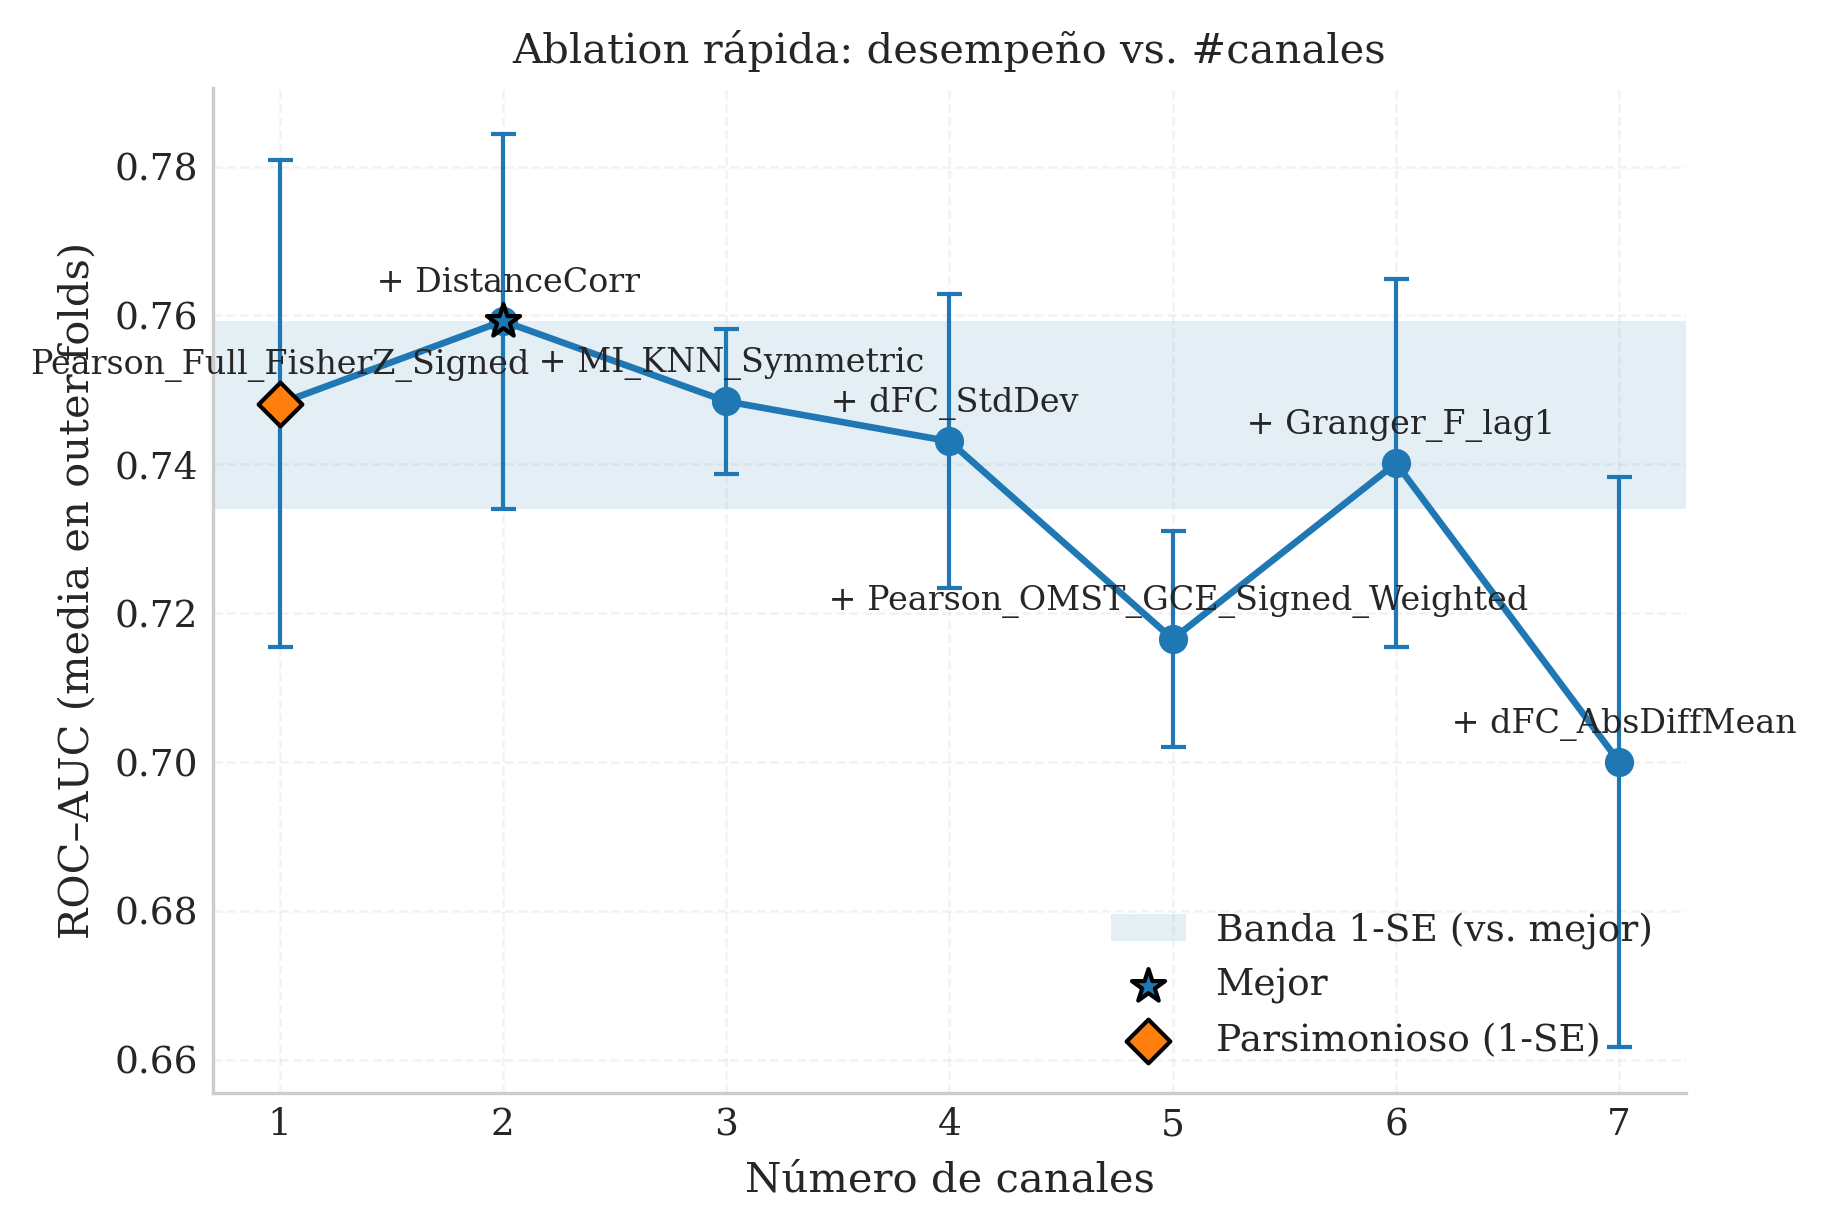

In [21]:
import re, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Rutas ---
SUMMARY_CSV = Path("/home/diego/Escritorio/limpio/ablation_full_run_fast/summary_ablation.csv")
FIGS_DIR = Path("Figures"); FIGS_DIR.mkdir(parents=True, exist_ok=True)
out_png = FIGS_DIR / "Fig_Appendix_AblationCurve.png"
out_pdf = FIGS_DIR / "Fig_Appendix_AblationCurve.pdf"

# --- Carga ---
df = pd.read_csv(SUMMARY_CSV)

# --- Utilidades de parseo ---
def parse_idx_list(s):
    if isinstance(s, str) and s.strip():
        return [int(x) for x in s.split()]
    return []

def parse_pretty_names(s):
    if not isinstance(s, str): return []
    s = s.strip().strip("[]")
    if not s: return []
    out = []
    for part in s.split(","):
        part = part.strip()
        if ":" in part:
            _, name = part.split(":", 1)
            out.append(name.strip())
        else:
            out.append(part)
    return out

df["channels_idx_list"] = df["channels_indices"].apply(parse_idx_list)
df["channels_names"] = df["channels_pretty"].apply(parse_pretty_names)
df["n_channels"] = df["channels_idx_list"].apply(len).astype(int)
df["step"] = pd.to_numeric(df["step"], errors="coerce").astype("Int64")
df["metric_mean"] = pd.to_numeric(df["metric_mean"], errors="coerce")
df["metric_std"] = pd.to_numeric(df["metric_std"], errors="coerce")

# --- Inferir #folds simple (usa 3 si no hay otra pista) ---
N_FOLDS = 3
df["std_err"] = df["metric_std"] / np.sqrt(N_FOLDS)

# --- Orden y etiquetas incrementales ---
df = df.sort_values(["step","n_channels"]).reset_index(drop=True)

def incremental_label(row, prev_row):
    if prev_row is None:
        return " + ".join(row["channels_names"]) if row["channels_names"] else ""
    prev_set = set(prev_row["channels_idx_list"]); curr_set = set(row["channels_idx_list"])
    added = [i for i in row["channels_idx_list"] if i in (curr_set - prev_set)]
    if row["channels_names"] and len(row["channels_names"]) == len(row["channels_idx_list"]):
        idx_to_name = dict(zip(row["channels_idx_list"], row["channels_names"]))
    else:
        idx_to_name = {i: f"Ch{i}" for i in row["channels_idx_list"]}
    return " + " + " + ".join(idx_to_name[i] for i in added) if added else ""

labels = []
prev = None
for _, r in df.iterrows():
    labels.append(incremental_label(r, prev))
    prev = r
df["label_incremental"] = labels

# --- Best y parsimonioso (1-SE) ---
best_idx = int(df["metric_mean"].idxmax())
best_row = df.loc[best_idx]
best_mean = float(best_row["metric_mean"])
best_se   = float(best_row["std_err"])
threshold = best_mean - best_se

candidates = df[df["metric_mean"] >= threshold]
parsimonious_idx = int(candidates.sort_values(["n_channels","metric_mean"], ascending=[True, False]).index[0])
parsimonious_row = df.loc[parsimonious_idx]

# --- Plot ---
plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 10, "axes.titlesize": 10, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9, "legend.fontsize": 9,
})
x = df["n_channels"].values
y = df["metric_mean"].values
se = df["std_err"].values

fig, ax = plt.subplots()
ax.plot(x, y, marker="o", linewidth=1.6)                       # línea única (apto B/N)
ax.errorbar(x, y, yerr=se, fmt="none", capsize=3, linewidth=1) # barras = SE

# Banda 1-SE respecto al mejor
ax.axhspan(threshold, best_mean, alpha=0.12, lw=0, label="Banda 1-SE (vs. mejor)")

# Marcas de Best y Parsimonious
ax.scatter([best_row["n_channels"]], [best_mean], s=70, zorder=3, marker="*",
           edgecolor="k", label="Mejor")
ax.scatter([parsimonious_row["n_channels"]], [parsimonious_row["metric_mean"]],
           s=55, zorder=3, marker="D", edgecolor="k", label="Parsimonioso (1-SE)")

# Etiquetas incrementales encima de cada punto
for xi, yi, lbl in zip(x, y, df["label_incremental"].values):
    if lbl:
        ax.annotate(lbl, (xi, yi), textcoords="offset points", xytext=(0, 7),
                    ha="center", fontsize=8)

ax.set_xlabel("Número de canales")
ax.set_ylabel("ROC–AUC (media en outer folds)")
ax.set_title("Ablation rápida: desempeño vs. #canales")
ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.6)
ax.legend(loc="lower right", frameon=False)

fig.tight_layout()
fig.savefig(out_png, dpi=300)
fig.savefig(out_pdf)
print(f"Guardado: {out_png} | {out_pdf}")
plt.show()
